# DQN, Deep Q Learning

In [2]:
import os
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple
from itertools import count
from PIL import Image

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gymnasium as gym

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
plt.style.use('ggplot')

## Set Configs

In [6]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [7]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [8]:
MEMORY_SIZE = int(1e4)
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

## Set Environment

In [9]:
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME, render_mode="rgb_array")

Environment Display:


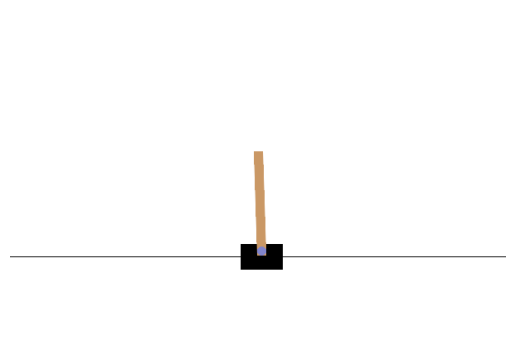

State space Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space Discrete(2)


In [10]:
print('Environment Display:')

# Reset the environment to get the initial state
obs = env.reset()

# Render the initial frame
frame = env.render()

# Display the frame using Matplotlib
plt.imshow(frame)
plt.axis('off')
plt.show()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

## Build DQN Architecture

In [11]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, height, width, action_size):
        """Initialize parameters and build model."""
        super(DQN, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Compute the size of the output from the conv layers
        def conv2d_size_outputs(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        convw = conv2d_size_outputs(conv2d_size_outputs(conv2d_size_outputs(width, 5, 3), 4, 2), 3, 1)
        convh = conv2d_size_outputs(conv2d_size_outputs(conv2d_size_outputs(height, 5, 3), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64
        
        # Fully connected layers
        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.head = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state into action values."""
        state = F.relu(self.conv1(state))
        state = F.relu(self.conv2(state))
        state = F.relu(self.conv3(state))
        state = state.view(state.size(0), -1)  # Flatten the output
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        state = F.relu(self.fc3(state))
        
        Qsa = self.head(state)
        
        return Qsa

## Set Replay Memory

In [12]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward'))

In [13]:
# a method for selecting a random batch of transitions for training
class ReplayMemory(object):
    """Fixed-size memory to store experience tuples."""
    
    def __init__(self, capacity):
        
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    # *args filled by state, action, next_state and reward variables
    def push(self, *args):
        """Add a new experience to memory."""
        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [14]:
memory = ReplayMemory(MEMORY_SIZE) # init capacity

## Extract Input

In [15]:
# using transforms from PyTorch to resize the screen
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.BICUBIC),
                    T.ToTensor()])

In [16]:
def get_cart_location(screen_width):
    
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    cart_location = int(env.state[0] * scale + screen_width / 2.0)
    
    return cart_location

In [17]:
def get_screen():
    
    # returned screen requested by gym is 800x1200x3, but sometimes smaller or larger
    # this will transpose it into torch order (C, H, W)
    screen = env.render().transpose((2, 0, 1))
    
    # cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4): int(screen_height*0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
        
    # strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    
    # convert to float, rescale, convert to torch tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # resize and add a batch dimension (B, C, H, W)
    return resize(screen).unsqueeze(0).to(device)

## Init Screen

In [18]:
# get screen size so that we can initialize layers correctly based on the shape
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

## Initialize DQN

In [19]:
# get number of actions from gym action space
n_actions = env.action_space.n

dqn_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(dqn_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(3, 3))
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2112, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (head): Linear(in_features=64, out_features=2, bias=True)
)

## Set Optimizer

In [20]:
optimizer = optim.RMSprop(dqn_net.parameters())

## Train DQN

In [21]:
steps_done = 0

# this will select an action accordingly to an epsilon greedy policy
def select_action(state):
    
    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            # here the network will pick action with the larger expected reward
            action = dqn_net(state).max(1)[1].view(1, 1)
            return action
    else:
        action = torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)
        return action

In [22]:
episode_durations = []

# a helper for plotting the durations of episodes
def plot_durations(i_episode, num_episodes):
    
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    
    plt.title(f'Training Episode: {i_episode}')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), color='green')
    
    # take 100 episode averages and plot them
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    # pause a bit so that plots are updated
    plt.savefig('./images/plot_of_training_result_cnn_dqn.png')
    plt.pause(0.001)
    
    if is_ipython and i_episode is not num_episodes:
        display.clear_output(wait=True)
        plt.show()
    else: return

In [23]:
# this function first samples a batch, concatenates all the tensors into a single one
# then computes Q(st, at) and V(st+1) = maxaQ(st+1, a), and combines them into our loss
def optimize_network():
    
    # this will skip the optimization process if there is no enough memory
    if len(memory) < BATCH_SIZE: return
    
    transitions = memory.sample(BATCH_SIZE)
    
    # this converts batch-array of transitions to transition of batch-arrays
    batch = Transition(*zip(*transitions))
    
    # compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.uint8, device=device)
    non_final_next_states = torch.cat([state for state in batch.next_state if state is not None])
    
    # concatenate all states, actions and rewards on the batch
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # compute V(s_{t+1}) for all next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # compute Q target
    Q_target = reward_batch + (GAMMA * next_state_values)
    
    # get the expected Q values
    # the network computes Q(s_t) then will select the columns of actions (a) taken
    # The (a) is the actions which would've been taken for each batch state according to dqn_net
    Q_expected = dqn_net(state_batch).gather(1, action_batch)
    
    # compute huber loss
    loss = F.smooth_l1_loss(Q_expected, Q_target.unsqueeze(1))
    
    # this will perform optimization for the network
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    optimizer.step()

In [24]:
def train_network(num_episodes):

    for i_episode in range(1, num_episodes+1):

        # initialize the environment and state
        env.reset()
        
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen

        for time_step in count():

            # select and perform an action using dqn network
            # state shape: batch, channel, height, width
            # action shape: 0 for left, 1 for right
            action = select_action(state)
            
            _, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # observe a new state
            last_screen = current_screen
            current_screen = get_screen()
            if not terminated:
                next_state = current_screen - last_screen
            else:
                next_state = None

            # store the transition in memory
            memory.push(state, action, next_state, reward)

            # move to the next state
            state = next_state

            # perform one step of the optimization on the target network
            optimize_network()

            if terminated or truncated:
                episode_durations.append(time_step + 1)
                plot_durations(i_episode, num_episodes)
                break

            # update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(dqn_net.state_dict())

    if not os.path.exists('./agents/'): os.makedirs('./agents/')
    torch.save(dqn_net.state_dict(), f'./agents/CNN_DQN_{ENV_NAME}.pth')
    print('Training completed.')
    env.render()
    env.close()
    plt.ioff()
    plt.show()

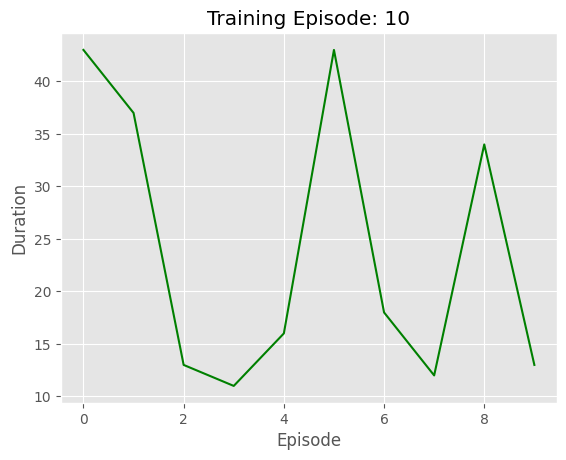

In [ ]:
print('Training the network...')
train_network(num_episodes=5000)

## 🎬 Watch The Smart Agent

In [ ]:
# load the weights of smart agent
dqn_net.load_state_dict(torch.load(f'./agents/CNN_DQN_{ENV_NAME}.pth'));

In [ ]:
num_episodes = 20
best_score = -np.inf

for i_episode in range(1, num_episodes+1):
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    total_score = 0
    
    for time_step in count():
        
        # select an action using the trained dqn network
        with torch.no_grad():
            action = dqn_net(state).max(1)[1].view(1, 1)
        env.render()
        
        next_state, reward, terminated, truncated, info  = env.step(action.item())
        
        # observe a new state
        last_screen = current_screen
        current_screen = get_screen()
        if not terminated:
            next_state = current_screen - last_screen
        else:
            next_state = None
                
        state = next_state
        total_score += reward
        if terminated or truncated:
            break
            
    if total_score > best_score: 
        best_score = total_score
        
    print(f'\rEpisode {i_episode}/{num_episodes}, Best Score: {best_score}', end='')  

env.close()

---